In [95]:
import numpy as np
import rdkit
import rdkit.Chem
import rdkit.Chem.AllChem
import rdkit.Chem.Draw
import pandas as pd
import sys
import json
import torch
import gpytorch
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.gaussian_process.kernels import (
    ConstantKernel, RBF, DotProduct, WhiteKernel, Matern, Exponentiation, ExpSineSquared, RationalQuadratic)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from reaction import ReactionAB
# from experiment import ExperimentalDataset
from features import MolFeatures
from theoretical import TheoSimulation

In [96]:
import re
import seaborn as sns

In [97]:
use_simulation_data = True

label_names = ["PCE", "Jsc", "Voc", "FF"]
new_data = pd.read_csv("data/dataset.csv")

# For the model selection only the first initial data is availbable
# new_data = new_data.iloc[:100, :]
samples, targets = [
    re.sub(r"[()' ]", "", x).split(",") for
    x in new_data["AB"].values
], new_data.loc[:, label_names].values

In [98]:
feat_cols = [
    "C",
    "N",
    "O",
    "H",
    "S",
    "F",
    "Cl",
    "NumAtoms",
    "AtomIsInRing",
    "AtomIsAromatic",
    "NumBonds",
    "BondIsConjugated",
    "BondIsAromatic",
    "NumRotatableBonds",
    "fr_C_O_noCOO",
    "fr_Al_COO",
    "fr_Ar_COO",
    "fr_Al_OH",
    "fr_Ar_OH",
    "fr_NH2",
    "fr_SH",
    "fr_sulfide",
    "fr_alkyl_halide",
    "ExactMolWt",
    "FpDensityMorgan3",
    "MolLogP",
    "MolMR",
    "FractionCSP3",
    "has_CN(C)C",
    "has_CNC",
    "has_C=NC",
    "has_Thiophene",
    "has_Pyrrole",
    "has_Benzimidazole",
    "has_Benzothiophene",
    "has_Naphthalene",
    "has_Biphenyl",
    # "TPSA"
]
theo_cols = [
    "dipole",
    "homo",
    "lumo",
    "gap",
    "energy",
    "a",
    "b",
    "c"
]

In [99]:
# Make reaction
reaction_engine = ReactionAB(file_name_a="Mol_Group_A.xlsx", file_name_b="Mol_Group_B.xlsx",
                             data_dir_path="./data")
mols = reaction_engine.run_combos(samples)

INFO: Reading excel files.
INFO: Reading structures.


100%|██████████| 149/149 [00:00<00:00, 795.87it/s]


In [100]:
feature_generator = MolFeatures(descriptor_list=feat_cols)
features = feature_generator(mols)

INFO: Making features:


100%|██████████| 149/149 [00:00<00:00, 324.59it/s]


In [108]:
if use_simulation_data:
    theo_generator = TheoSimulation(file_name="Theo_simu.xlsx", descriptor_list=theo_cols, data_dir_path="./data")
    _, theos = theo_generator.labels_for_combos(samples)
    features = np.concatenate([features, theos], axis=-1)

columns = {"ID": ["".join(x) for x in samples]}
columns = {}
columns.update({x: features[:, i] for i, x in enumerate(feat_cols)})
if use_simulation_data:
    columns.update({x: theos[:, i] for i, x in enumerate(theo_cols)})
columns.update({x: targets[:, i] for i, x in enumerate(label_names)})
columns.update({"MolFormular": [rdkit.Chem.rdMolDescriptors.CalcMolFormula(m) for m in mols]})
columns.update({"SMILES": [rdkit.Chem.MolToSmiles(m) for m in mols]})

In [57]:
ignore_samples_mask = targets[:, 2] > 0.2

In [109]:
df = pd.DataFrame(columns)
df.to_csv("data/feature_dataset.csv", index=False)
df.columns

Index(['C', 'N', 'O', 'H', 'S', 'F', 'Cl', 'NumAtoms', 'AtomIsInRing',
       'AtomIsAromatic', 'NumBonds', 'BondIsConjugated', 'BondIsAromatic',
       'NumRotatableBonds', 'fr_C_O_noCOO', 'fr_Al_COO', 'fr_Ar_COO',
       'fr_Al_OH', 'fr_Ar_OH', 'fr_NH2', 'fr_SH', 'fr_sulfide',
       'fr_alkyl_halide', 'ExactMolWt', 'FpDensityMorgan3', 'MolLogP', 'MolMR',
       'FractionCSP3', 'has_CN(C)C', 'has_CNC', 'has_C=NC', 'has_Thiophene',
       'has_Pyrrole', 'has_Benzimidazole', 'has_Benzothiophene',
       'has_Naphthalene', 'has_Biphenyl', 'dipole', 'homo', 'lumo', 'gap',
       'energy', 'a', 'b', 'c', 'PCE', 'Jsc', 'Voc', 'FF', 'MolFormular',
       'SMILES'],
      dtype='object')

In [59]:
df

,C,N,O,H,S,F,Cl,NumAtoms,AtomIsInRing,AtomIsAromatic,...,lumo,gap,energy,a,b,c,PCE,Jsc,Voc,FF
0,53.0,2.0,4.0,44.0,0.0,0.0,0.0,103.0,49.0,48.0,...,-1.09580,3.42527,-66756.053428,0.005266,0.000512,0.000470,14.653520,19.925500,0.969192,0.758792
1,46.0,3.0,4.0,41.0,0.0,0.0,0.0,94.0,42.0,42.0,...,-1.06150,3.44822,-60945.716400,0.005484,0.000765,0.000710,13.625333,19.384833,0.936152,0.750825
2,53.0,2.0,5.0,42.0,0.0,0.0,0.0,102.0,49.0,48.0,...,-2.19951,2.41756,-68767.958328,0.005045,0.000522,0.000477,15.390800,21.271833,0.969527,0.746271
3,45.0,3.0,4.0,39.0,0.0,0.0,0.0,91.0,42.0,42.0,...,-1.20065,3.29389,-59877.467861,0.005563,0.000785,0.000699,12.894920,19.132333,0.907476,0.742704
4,47.0,2.0,4.0,42.0,0.0,0.0,0.0,95.0,42.0,42.0,...,-0.74921,3.77481,-60509.519684,0.005454,0.000775,0.000691,15.395600,21.044333,0.953546,0.767220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,43.0,4.0,0.0,32.0,0.0,0.0,0.0,79.0,42.0,42.0,...,-1.28162,3.66775,-51003.328880,0.006639,0.001516,0.001260,17.729460,21.540000,1.003638,0.820111
145,37.0,1.0,0.0,29.0,2.0,0.0,0.0,69.0,36.0,36.0,...,-1.53461,3.40552,-61939.153626,0.006502,0.002071,0.001635,17.498546,22.125192,1.040584,0.760042
146,30.0,5.0,2.0,21.0,1.0,0.0,0.0,59.0,27.0,27.0,...,-3.21871,1.86826,-53766.639669,0.008039,0.002450,0.001907,17.266060,21.693833,0.984527,0.808406
147,38.0,9.0,0.0,19.0,2.0,0.0,0.0,68.0,36.0,36.0,...,-3.58838,2.08959,-74711.052861,0.005947,0.001220,0.001020,17.946951,22.437049,0.998985,0.800692


<Axes: >

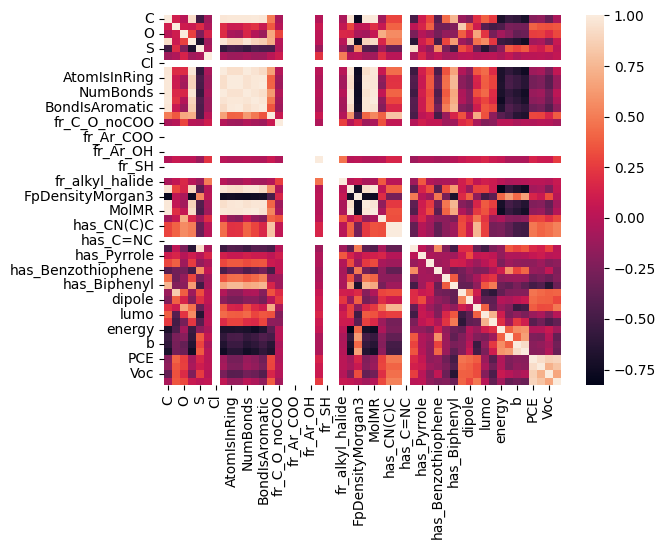

In [60]:
sns.heatmap(df.corr(), annot=False)

In [84]:
from sklearn.decomposition import PCA
pca = PCA(n_components=14)
features_pca = pca.fit_transform(features)

In [93]:
selected_targets = targets[ignore_samples_mask]
selected_features = features[ignore_samples_mask]
y_scaler = StandardScaler(with_std=True, with_mean=True, copy=True)
x_scaler = StandardScaler(with_std=True, with_mean=True, copy=True)
scaled_targets = y_scaler.fit_transform(selected_targets)
scaled_features = x_scaler.fit_transform(selected_features)

In [94]:
# For validation, use a KFold() split.
kf = KFold(n_splits=7, random_state=0, shuffle=True)
split_indices = kf.split(X=scaled_features)

print("Fitting model to data...")
r2_scores = []
for train_index, test_index in split_indices:
    ytrain = scaled_targets[train_index]
    ytest = scaled_targets[test_index]
    xtrain = scaled_features[train_index]
    xtest = scaled_features[test_index]

    # model = LinearRegression().fit(xtrain, ytrain)
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)

    model.fit(xtrain, ytrain)

    predicted = model.predict(xtest)
    predicted = y_scaler.inverse_transform(predicted)
    test_labels_rescaled = y_scaler.inverse_transform(ytest)
    r2_scores.append(r2_score(test_labels_rescaled, predicted))
    print("R2 score: ", r2_scores[-1])

print("Mean R2 score: ", np.mean(r2_scores))

Fitting model to data...
R2 score:  0.6497620522570919
R2 score:  0.2350504206838752
R2 score:  0.5758159059871653
R2 score:  0.6363846549629789
R2 score:  0.39559037217133675
R2 score:  0.5150415814430486
R2 score:  0.07076441775522455
Mean R2 score:  0.439772772180103


In [91]:
selected_targets = targets[ignore_samples_mask]
selected_features = features_pca[ignore_samples_mask]
y_scaler = StandardScaler(with_std=True, with_mean=True, copy=True)
x_scaler = StandardScaler(with_std=True, with_mean=True, copy=True)
scaled_targets = y_scaler.fit_transform(selected_targets)
scaled_features = x_scaler.fit_transform(selected_features)

In [92]:
# For validation, use a KFold() split.
kf = KFold(n_splits=7, random_state=0, shuffle=True)
split_indices = kf.split(X=scaled_features)

print("Fitting model to data...")
r2_scores = []
for train_index, test_index in split_indices:
    ytrain = scaled_targets[train_index]
    ytest = scaled_targets[test_index]
    xtrain = scaled_features[train_index]
    xtest = scaled_features[test_index]

    # model = LinearRegression().fit(xtrain, ytrain)
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)

    model.fit(xtrain, ytrain)

    predicted = model.predict(xtest)
    predicted = y_scaler.inverse_transform(predicted)
    test_labels_rescaled = y_scaler.inverse_transform(ytest)
    r2_scores.append(r2_score(test_labels_rescaled, predicted))
    print("R2 score: ", r2_scores[-1])

print("Mean R2 score: ", np.mean(r2_scores))

Fitting model to data...
R2 score:  0.2982333635793138
R2 score:  0.38806250147043986
R2 score:  0.4512543077001629
R2 score:  0.5152014785108593
R2 score:  0.3877250572867841
R2 score:  0.39550728829968695
R2 score:  0.39046130480743896
Mean R2 score:  0.40377790023638377
